In [1]:
"""
visualize results for test image
"""

import os
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
from collections import Counter

import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from skimage import io
from skimage.transform import resize

from models import *
import transforms as transforms

In [2]:
cut_size = 44

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fit_pred(path='images/1.jpg'):
    raw_img = io.imread(path)
    gray = rgb2gray(raw_img)
    gray = resize(gray, (48,48), mode='symmetric').astype(np.uint8)

    img = gray[:, :, np.newaxis]

    img = np.concatenate((img, img, img), axis=2)
    img = Image.fromarray(img)
    inputs = transform_test(img)

    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    net = VGG('VGG19')
    checkpoint = torch.load(os.path.join('../models/FER2013_VGG19', 'PrivateTest_model.t7'), map_location='cpu')
#     checkpoint = torch.load('../models/classifier.t7', map_location='cpu')
    net.load_state_dict(checkpoint['net'])
    # net.cuda()
    net.eval()

    ncrops, c, h, w = np.shape(inputs)

    inputs = inputs.view(-1, c, h, w)
    # inputs = inputs.cuda()
    inputs = Variable(inputs, volatile=True)
    outputs = net(inputs)

    outputs_avg = outputs.view(ncrops, -1).mean(0)  # avg over crops

    score = F.softmax(outputs_avg)
    _, predicted = torch.max(outputs_avg.data, 0)

    predicted_emotion = class_names[int(predicted.cpu().numpy())]
    return predicted_emotion

In [3]:
from tqdm import tqdm
from IPython.display import clear_output

In [4]:
!ls ../../data_philita/

train_A train_B


In [5]:
PATH = '../../data_philita/'
POS = PATH + 'train_A'
NEG = PATH + 'train_B'

In [22]:
# def check_emotion(path):
res = {}
path = POS
for im in tqdm(os.listdir(path)[:1000]):
    res[im] = fit_pred(path='{}/{}'.format(path, im))
    clear_output()






100%|██████████| 1000/1000 [07:48<00:00,  2.20it/s]






In [ ]:
Counter(res.keys())

In [8]:
im

'068563.jpg'

In [16]:
# def check_emotion(path):
res = []
path = NEG
false_pos = []
for im in tqdm(os.listdir(path)[:1000]):
    ans = fit_pred(path='{}/{}'.format(path, im))
    res.append(ans)
    if ans == 'Happy':
        false_pos.append(im)
    clear_output()






100%|██████████| 1000/1000 [07:37<00:00,  2.02it/s]






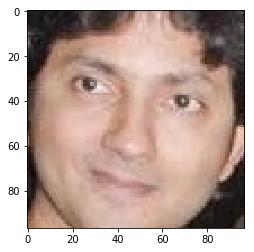

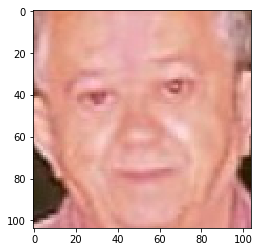

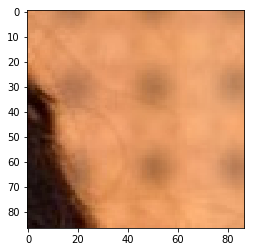

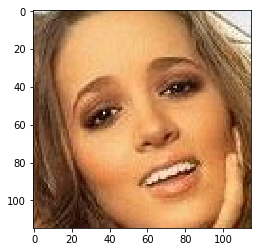

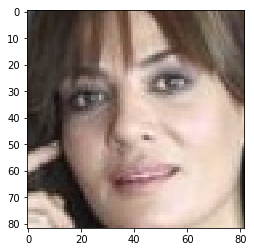

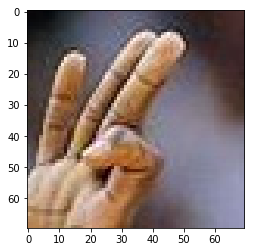

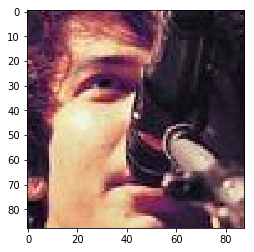

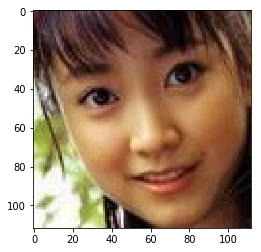

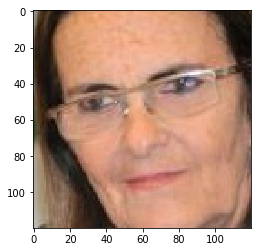

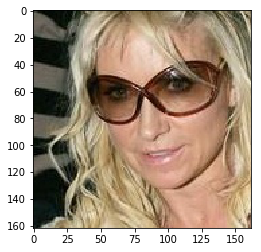

In [21]:
for im in false_pos[:10]:
    img = plt.imread('{}/{}'.format(path, im))
    plt.imshow(img)
    plt.show()

In [46]:
Counter(res)

Counter({'Neutral': 569,
         'Fear': 51,
         'Angry': 69,
         'Happy': 120,
         'Sad': 172,
         'Surprise': 19})

In [47]:
import h5py
filename = '../data/CK_data.h5'
f = h5py.File(filename, 'r')

In [49]:
# List all groups
print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

# Get the data
data = list(f[a_group_key])

Keys: KeysView(<HDF5 file "CK_data.h5" (mode r)>)


преобразуем результаты: если лицо распознано не как счастливое -- считаем, что оно без улыбки

In [71]:
results_binary = ['Happy' if i == 'Happy' else 'Sad' for i in results]

In [114]:
happy_idx = np.where(np.array(data.Emotion[:N]) == 'Happy')[0]

In [122]:
sum(data.Emotion[:N] == np.array(results_binary)) / N

0.737

In [120]:
sum(data['Emotion'][happy_idx] == np.array(results_binary)[happy_idx])/len(data['Emotion'][happy_idx])

0.5705882352941176

In [126]:
import torchvision

traced_script_module = torch.jit.trace(net, inputs)

traced_script_module.save("emotion_recognition.pt")

как видно, есть куда расти в определении эмоций